# LDDMM: how to visualize registration results?

In [1]:
from pathlib import Path

import pyvista as pv
from IPython.display import Image

from polpo.preprocessing import Filter, Map, Sorter
from polpo.preprocessing.mesh.io import PvReader
from polpo.preprocessing.path import FileFinder, IsFileType, PathShortener
from polpo.preprocessing.str import DigitFinder

In [2]:
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

In [3]:
OUTPUTS_DIR = Path("results") / "registration"
INITIAL_REGISTRATION_DIR = OUTPUTS_DIR / "initial_registration"

In [4]:
pv_reader = Map(PvReader())

In [5]:
vtk_files = (
    FileFinder(
        INITIAL_REGISTRATION_DIR,
        rules=IsFileType("vtk"),
    )
    + Sorter()
)()

## Template and control points

In [6]:
(template,) = (Filter(lambda x: "Template" in x) + pv_reader)(vtk_files)

(control_points,) = (Filter(lambda x: "control_points" in x) + pv_reader)(vtk_files)

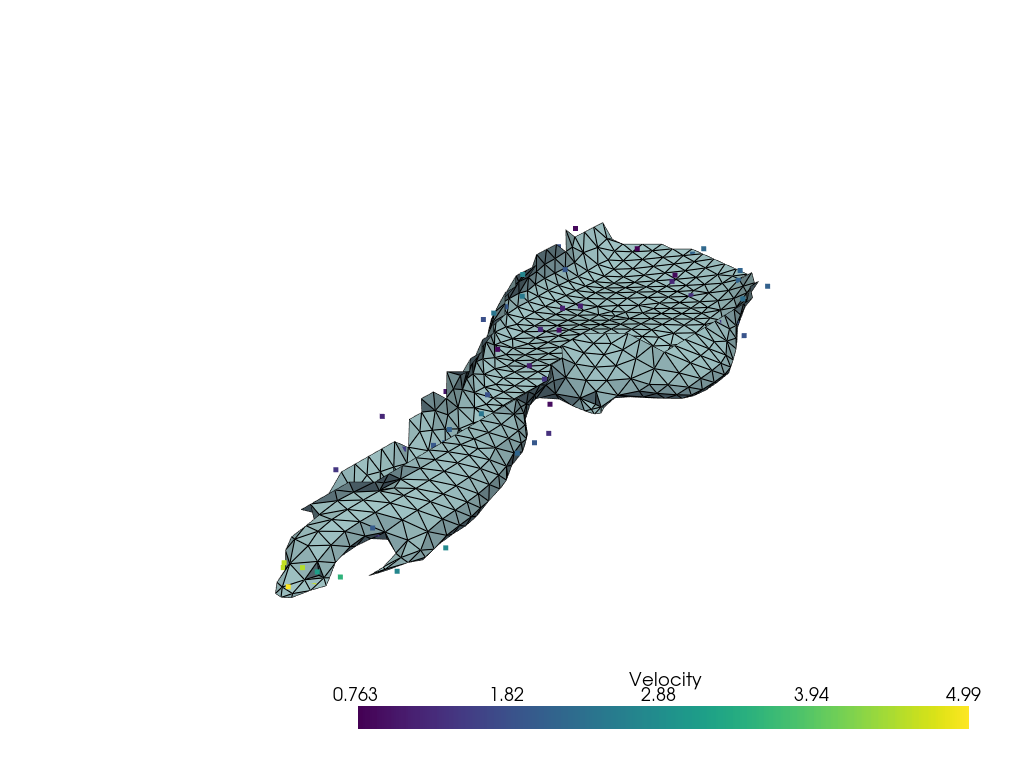

In [7]:
pl = pv.Plotter()

pl.add_mesh(template, show_edges=True)

control_points.set_active_scalars("Velocity")
pl.add_points(control_points)

pl.show()

## Target and reconstructed meshes

In [8]:
names = ["Reconstruction", "target_shape"]

meshes_reader = Filter(lambda x: any([name in x for name in names])) + pv_reader

In [9]:
reconstructed, target = meshes_reader(vtk_files)

(reconstructed.points.shape[0], target.points.shape[0])

(666, 607)

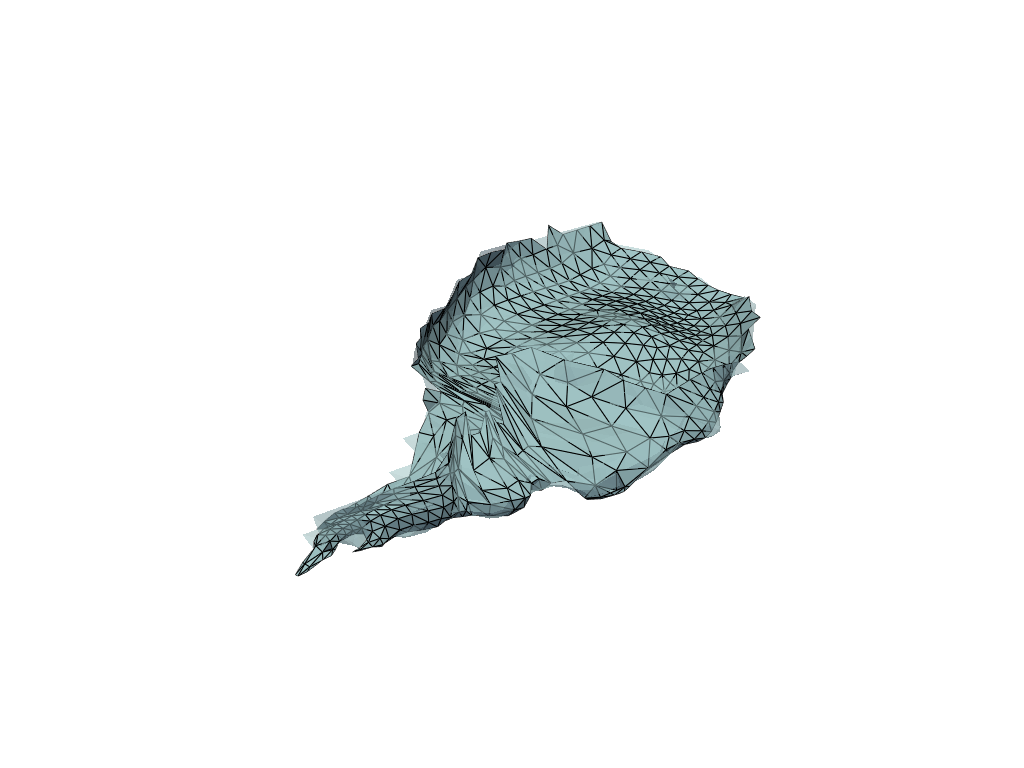

In [10]:
pl = pv.Plotter()

pl.add_mesh(reconstructed, show_edges=True)
pl.add_mesh(target, opacity=0.55)

pl.show()

## Flow

In [11]:
flow_meshes_reader = (
    FileFinder(
        INITIAL_REGISTRATION_DIR,
        rules=[IsFileType("vtk"), lambda x: "flow" in x],
    )
    + Sorter(key=PathShortener() + DigitFinder(index=0))
    + Map(PvReader())
)

meshes = flow_meshes_reader()

In [12]:
gif_name = INITIAL_REGISTRATION_DIR / "flow.gif"

pl = pv.Plotter(notebook=False, off_screen=True)

pl.open_gif(gif_name.as_posix())

pl.add_mesh(meshes[0], show_edges=True)
pl.write_frame()

for mesh in meshes[1:]:
    pl.update_coordinates(mesh.points, render=False)
    pl.write_frame()

pl.close()

/home/luisfpereira/miniconda3/envs/py12/lib/python3.12/site-packages/pyvista/plotting/plotter.py:4872: PyVistaDeprecationWarning: This method is deprecated and will be removed in a future version of PyVista. Directly modify the points of a mesh in-place instead.
  warnings.warn(


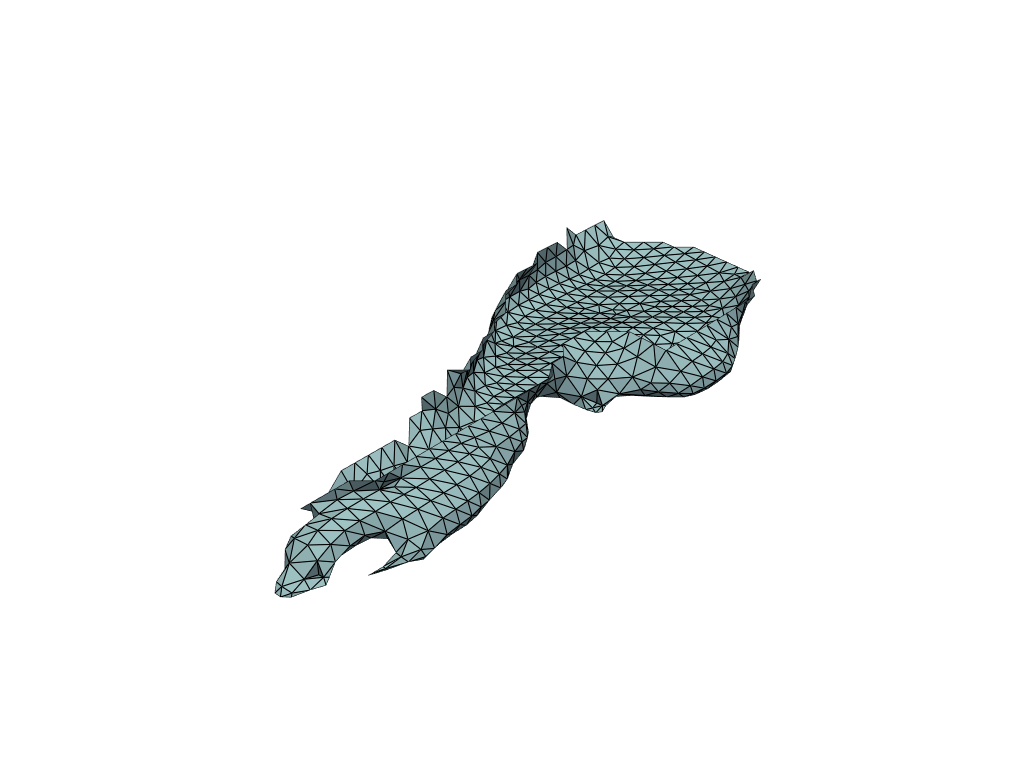

In [13]:
Image(open(gif_name, "rb").read())